# Description 

**Project name**: Predicting the energy output of a power plant with multiple linear regressions (2020)

**Author** : Seydou DIA

**Last update**: 08-24-2020

**Entire notebook running time**:55s <br>with AMD Ryzen 7 3750H - Radeon Vega Mobile Gfx 2.30 GHz

**Contact**:<br>
* [Linkedin](https://www.linkedin.com/in/seydou-dia-325b04139)
* @:seydou.dia@insa-lyon.fr

For more projects on machine learning and energy click here >
[Data Science Portfolio](https://seydoudia.github.io/Data-Science-portfolio/)

The goal of this notebook is to predict the energy output of a power plant based on the ambient temperature, humidity, pressure and exaust vaccum with the help of linear regressions.

We will then verify the assumptions made when building the model in order to check if we have the best linear unbiased estimator (Gaus Markov Theorem)
Also we will explore two methods of performing linear regressions with python. In the first part we will be using scikit-learn and second one we will be using stats model.

Concerning the dataset, it contains data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. The features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V).

A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance.

# Setup

In [39]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports

In [40]:
# os related
from os import environ as env
from os.path import join

# data related
import pandas as pd
import numpy as np

# visual related
import matplotlib.pyplot as plt
import seaborn as sns


# ml related
from sklearn.model_selection  import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.tsa.api as smt
from scipy import stats

## Paths

In [41]:
DIR_ROOT = join(env["CODE_PATH"], "Power_Plant")
DIR_CODE = join(DIR_ROOT, "Code")
DIR_RAW = join(DIR_ROOT, 'Raw_Data')


POWER_CSV = join(DIR_RAW, 'power.csv')

## Functions

these functions will be used at some point in the projet. The reader is free to come back to this section to get a better understanding of the code later.

In [42]:
def split_train_test(data, test_ratio):
    """Functions that splits dataset between training and test set 
        Args:
        Data(pandas.Dataframe): Data to split
        Returns:
            training set and testing set"""
    
    shuffled_indices = np.random.permutation(len(data)) # shuffle indexes
    test_set_size = int(len(data) * test_ratio) 
    test_indices = shuffled_indices[:test_set_size] # Retrieving test index
    train_indices = shuffled_indices[test_set_size:] # Retrieving train index
    return data.iloc[train_indices], data.iloc[test_indices]

In [ ]:
def display_score(scores):
    print("Scores : ", scores)
    print("Mean : ", scores.mean())
    print("Std : ", scores.std())

In [61]:
def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,2)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'}, ci=95)
    sns.regplot(x=y, y=y, lowess=True, ax=ax[0], line_kws={'color': 'orange'}, ci=95)
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')

In [66]:
def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])
    print('\n Breusch-Pagan test ----')
    print(bp_test)
   

# Project

## Loading and preppin data

In [43]:
col_names = ["ambient_temp", "exhaust_vaccum", "ambient_pressure",
             "relative_humidity", "energy_output"]
df = pd.read_csv(POWER_CSV, header=None, names=col_names)

In [44]:
df.head()

,ambient_temp,exhaust_vaccum,ambient_pressure,relative_humidity,energy_output
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ambient_temp       9568 non-null   float64
 1   exhaust_vaccum     9568 non-null   float64
 2   ambient_pressure   9568 non-null   float64
 3   relative_humidity  9568 non-null   float64
 4   energy_output      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


By taking a first look at our data we can see that we have 9568 different data points. None of them are missing. This was predictable since we fetched the data on a dedicated website. It must have been prepared before being published.

Also, something interesting to notice here, is that neither of these columns correspond to a datetime. One could think that having information about date could be useful since the energy production is strongly correlated with the hour of day, day of week or even the season. Nonetheless, let's not forget that in this project, we are always in the case where the power plant is set to work with full load. Thus having a datetime is not that useful.


Before doing any analysis on our data, let's split our data between test and training set.

In [46]:
df_train, df_test = split_train_test(df, 0.2) # Check beginning of notebook for function code

Let us know look our data is correlated and more specifficaly how the energy output is linked with the rest of our data.

In [47]:
df_train.corr()['energy_output']

ambient_temp        -0.948111
exhaust_vaccum      -0.870093
ambient_pressure     0.516788
relative_humidity    0.394518
energy_output        1.000000
Name: energy_output, dtype: float64

We can see that ambient temperature and exhaust vaccum have strong correlation with energy output. Although ambient pressure and relative humidity correlation coefficient are a bit smaller than the two previous ones, there is still important correlation. To get a better idea of our data, let's do a pairplot.


D:\logiciel\Anaconda\envs\ml_work\lib\site-packages\seaborn\axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


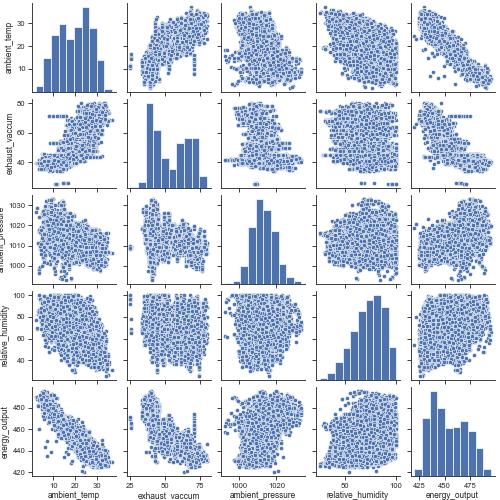

In [48]:
sns.set(style="ticks")
sns.pairplot(df_train, size=2)

The pairplot is very useful when building a linear regression model since it enables the data scientist to observe the relation between the data that he/she as at his/her disposal. In our case we will focus on the first hand on the last line of our plot.


As expected, energy output is strongly correlated with ambient temperature and exhaust vaccum. Concerning the two other variables, it is quite complicated to see a strong a correlation with the energy output but we will keep those variable in our model in the first place.

Another interesting thing is the apparent correlation between exhaust vaccum and ambient temperature but we will talk about it later. 

In [49]:
y = df_train['energy_output'].copy()
energy_labels = df_train['energy_output'].copy()

In [50]:
y

148     452.27
2307    464.72
3303    484.21
7359    465.00
2137    438.64
         ...  
8419    480.05
9010    457.09
222     463.57
1339    478.08
7288    469.32
Name: energy_output, Length: 7655, dtype: float64

In [51]:
X = df_train.drop('energy_output', axis=1)

In [69]:
X.head(8)

,ambient_temp,exhaust_vaccum,ambient_pressure,relative_humidity
148,21.95,57.76,1018.02,67.72
2307,17.19,43.14,1014.34,68.62
3303,8.35,43.79,1016.20,85.23
7359,13.90,39.59,1011.84,94.74
2137,29.63,69.59,1008.30,72.53
8571,17.00,49.78,1005.32,100.10
8889,7.76,37.70,1014.82,76.47
6517,13.44,39.64,1013.23,73.43


## Linear regression with Scikit Learn

In [53]:
X_prepared = X.values.reshape(len(X.index), len(X.columns))

In [54]:
X_prepared

array([[  21.95,   57.76, 1018.02,   67.72],
       [  17.19,   43.14, 1014.34,   68.62],
       [   8.35,   43.79, 1016.2 ,   85.23],
       ...,
       [  10.11,   41.62, 1017.17,   97.82],
       [   7.47,   40.64, 1020.47,   94.8 ],
       [  14.59,   35.71, 1015.19,   54.13]])

In [55]:
lin_reg_sk = LinearRegression()
lin_reg_sk.fit(X_prepared, energy_labels)

LinearRegression()

In [56]:
energy_predictions = lin_reg_sk.predict(X_prepared)
lin_mse = mean_squared_error(energy_labels, energy_predictions)
lin_rmse = np.sqrt(lin_mse)


In [57]:
print(f'RMSE: {lin_rmse}')
print(f'Coefficients: {lin_reg_sk.coef_}')
print(f'Intercept: {lin_reg_sk.intercept_}')

RMSE: 4.566874703619111
Coefficients: [-1.96582689 -0.23833105  0.06591938 -0.15464364]
Intercept: 450.4635280406866


The model gives us a rmse of 4.57 MWH which pretty much acceptable since the mean energy output is 454 MWH.

Now, stopping our project there wouldn't be a wrong thing, nonetheless, if we want to be rigorous and respect the assumptions when building a linear regression model, we ought to perform more work in order to validate the model. Although Scikit-Learn is an incredible python module, we will be using the stats model module for the rest of the project in order to obtain more details about our model.

## Linear regression with Stats Model

We ought to add ones for the intercept.

In [58]:
X_constant = sm.add_constant(X)

In [59]:
X_constant.head()

,const,ambient_temp,exhaust_vaccum,ambient_pressure,relative_humidity
148,1.0,21.95,57.76,1018.02,67.72
2307,1.0,17.19,43.14,1014.34,68.62
3303,1.0,8.35,43.79,1016.20,85.23
7359,1.0,13.90,39.59,1011.84,94.74
2137,1.0,29.63,69.59,1008.30,72.53


In [60]:
lin_reg = sm.OLS(y,X_constant).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          energy_output   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.473e+04
Date:                Mon, 24 Aug 2020   Prob (F-statistic):               0.00
Time:                        14:55:47   Log-Likelihood:                -22489.
No. Observations:                7655   AIC:                         4.499e+04
Df Residuals:                    7650   BIC:                         4.502e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               450.4635     10.946     41.154      0.000     429.007     471.920
ambient_temp         -1.9658      0.017   -114.586      0.000      -1.999      -1.932
exhaust_vaccum       -0.2383      0.008    -29.108      0.000      -0.254      -0.222
ambient_pressure      0.0659      0.011      6.206      0.000       0.045       0.087
relative_humidity    -0.1546      0.005    -33.179      0.000      -0.164      -0.146
==============================================================================
Omnibus:                      915.864   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4899.075
Skew:                          -0.453   Prob(JB):                         0.00
Kurtosis:                       6.813   Cond. No.                     2.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now one could stop here and just stick with these results. But someting important that hasn't been done here is the verification of assumptions when building a linear model.

## Verifying assumptions

Now that we have fiited our model, we will verify the assumptions that will ensure us that our model is the best unbiased predictor. 


**Assumptions to verify:**

- Linearity of the model

- Abscence of collinearity between independant variables

- Homoscedacity

- Normal distribution of residuals with mean of zero

- Independance of residuals and abscence of autocorrelation

### Linearity of the model

When building a linear regression model, there must be a linear relation between the dependant variable, in our case y, and the indenpendant variable, here X. Trying to fit data with non-linear patterns with a linear model will lead to important predictions errors.

To test the linearity of the model, we can plot the Observed vs Predicted Values or Residuals vs Predicted Values. 

For the first plot, will are ideally supposed to obtain a perfect line following the functions f(x)=x. Concerning the second plot, we are ideally supposed to obtain a line again, but in this case it should be f(x)=0.

<IPython.core.display.Javascript object>


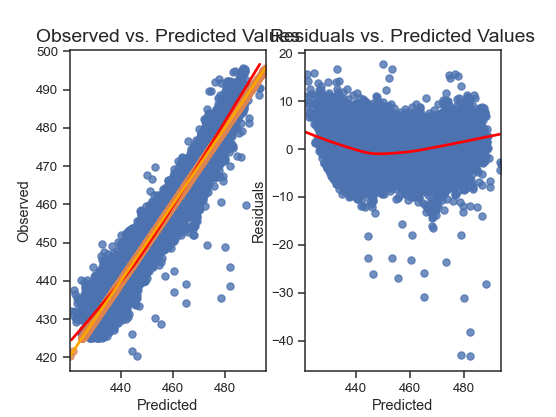

In [62]:
linearity_test(lin_reg, y) # Check beginning of notebook for function code

By looking at the plot on the left, we can see that the model is pretty much linear. <br>
On top of plotting Observed vs Predicted values in red, we have also plotted the function f(x)=x.
Although we can notice a slight error between the two curves, we can assume that the linearity condition is verified.


Concerning the second plot we can see that we are making important errors for extreme values of energy output. This could be due to outliers in our data.

If the linearity condition were not satisfified here are potential solutions



- Apply non linear transformation to our features or dependant variable
- Add transformed feature to the already existing ones of the model
- Find additional data for our model

### Mean of residuals equal to 0

To verify this condition we just have to calculate the mean with the help of built-in fucntions

In [63]:
lin_reg.resid.mean()

3.617781014890355e-13

Giving the value above, we can of course consider the expectation of residuals being 0.

### Abscence of strong multicollinearity - Variance Inflation Factor Method

The abscence of collinearity between features is very important when building a multiple linear regression model since it is important for the features to be independant.

In order to study collinearity, we will use what we call the variance inflation factor method, also called the "**vif**". The higher this factor is, and the stronger the collinearity is. Depending on the work you are performing one will set different threshold values for deciding to keep or not a feature in the model. Common values are 5 or 10 depending of the constraints we choose. In our case we will take 10. Which means that if the vif for one of our features is above 10, we will remove it from our dataset. If it is below, we will keep it.

<br> For more information about the variance inflation factor, check the references at the end of the project.



In [64]:
vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif': vif[1:]}, index=X.columns).T

,ambient_temp,exhaust_vaccum,ambient_pressure,relative_humidity
vif,5.99,3.946792,1.450043,1.701524


We can see that there is strong collinearity between ambient temperature and the other features. Nonetheless it is below the threshold we have choosen for this project. Furthermore, let's not forget that the ambient temperature is the feature that is correlated our dependent variable, here the energy output of our power plant. Thus, dropping it wouldn't be a smart choice.

### No autocorrelation of residuals

<IPython.core.display.Javascript object>


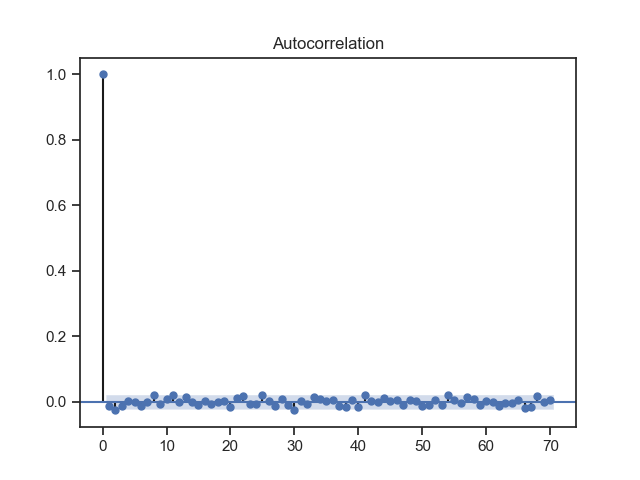

In [71]:
acf = smt.graphics.plot_acf(lin_reg.resid, lags=70 , alpha=0.05)
acf.show()

We can clearly see that there isn't any autocorrelation in our data which is a good thing. We are able to validate this assumption in our model.

### Homoscedacity 

Having non-constant variance can become problematic when running a linear regression model since it makes it difficult to find the true standard deviation of the forecast errors. This phenomenon will result in confidence intervals that are to wide or narrow.



<IPython.core.display.Javascript object>


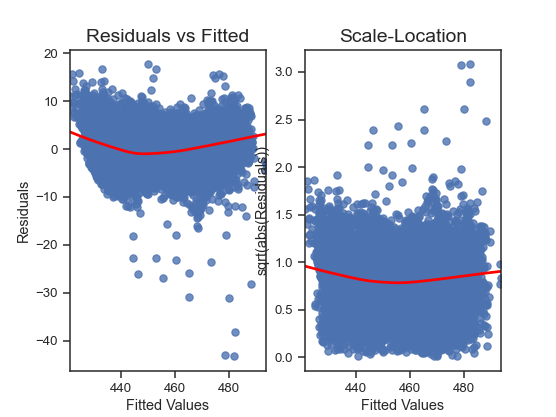


 Breusch-Pagan test ----
                                   value
Lagrange multiplier statistic  26.980037
p-value                         0.000020
f-value                         6.764445
f p-value                       0.000020


In [67]:
homoscedasticity_test(lin_reg) # Check beginning of notebook for function code

To verify the homoscedasticity, we will be using the Breusch-Pagan test. is the p-value is less than 0.05 (5%) then we will reject the null hypothesis which is the presence of homoscedacity.

As we can see, we have a p-value of 0.0001 which means that we can reject the null hypothesis of homoscedasticity.

To solve this problem we could:

- Transform the dependant variable using the log of the dependant variable

- Redefine the dependent variable

- Use weighted regression

### Normal distribution of residuals

To verify the normal distribution of residuals, we will use a qq-plot.

<IPython.core.display.Javascript object>


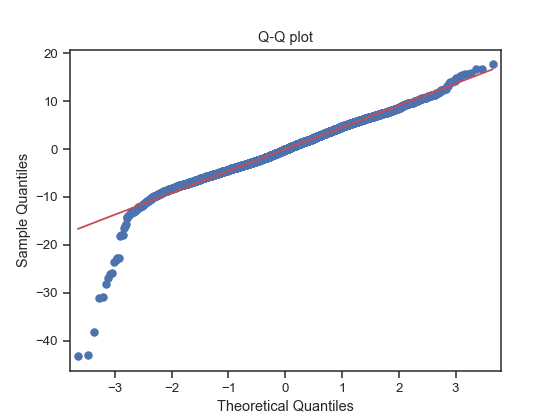

In [68]:
sm.ProbPlot(lin_reg.resid).qqplot(line='s');
plt.title('Q-Q plot');

We can see that for low values of residuals, we do not not respect the required distribution. One way of solving this problem could be to perform a more in depth analysis of the data in order to apply transformation or even remove data points that are outliers.

# Conclusion

Throughout this project, we have gone though the different steps when building a linear regression model. From the pre-analysis of the data, to the verification of the assumptions.<br>
Although it could seem simple to build a linear regression model with the commonly used module. One should not forget to verify the assumption when building the model before validating it. Scikit-Learn is a fast and easy to use module that is very popular around the data science community but sometimes makes us forget the mathematics that are behind the code.
<br> I invite every data enthusiast to give great importance to this aspect of Machine Learning and Data Science, starting by understanding the assumptions behind the linear regression is great thing since it can cost you job interviews (speaking by experience).

Voila! this is the end of the notebook, hope you enjoyed it and feel free to contact me if you have any questions or if you are interested on working on a project.




"Keep moving, Keep growing, Keep learning and see you at work"
D.W.


Contact:

- [Linkedin](https://www.linkedin.com/in/seydou-dia-325b04139/)
- @:seydou.dia@insa-lyon.fr


For more projects on machine learning, energy, sustainable and socio-economic development click here >
[Data Science Portfolio](https://seydoudia.github.io/Data-Science-portfolio/)

<br><br><br>
**References used to conduct the project :**


- ZACH (2020) *How to Perform a Breusch-Pagan Test in Python*. STATOLOGY
- Eryk Lewinson, (2019). *Verifying the Assumptions of Linear Regression in Python and R*. TowardsDataScience
- Aurélien Géron, (2017). *Hands-On Machine Learning with Scikit-Learn and TensorFlow*. O'reilly
- Wes McKinney, (2017). *Python for Data Analysis*. O'reilly
- Ben Lambert, (2013). *Variance Inflation Factors: testing for multicollinearity*. Youtube video
- Weisberg, S. (1983). *Diagnostics for Heteroskedasticity in Regression*. Biometrika



**END OF NOTEBOOK**